In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import time
import os
import numpy as np
import matplotlib.pyplot as plt

from utils.data_utils import load_config, load_tensor, LDL_Stim_Dataset,read_data_inference
from utils.train_utils import train, validate
from utils.inference_utils import get_representation,learn_B_for_one_sample, estimate_y_one_sample
from utils.inference_utils import calculate_mae, learn_B, estimate_y, get_tsne
from utils.loss import recon_loss, sup_loss,matching_loss, AverageMeter
from config.config import DEVICE
from models.models import Trans_Encoder,Trans_Decoder,linear_cls

## Load Data

In [2]:
data_path = "./data/sync6d-p10-seed-100"+ "/{}-{}.{}"
train_dataset = LDL_Stim_Dataset(data_path, fold = 'train',device = DEVICE)
val_dataset = LDL_Stim_Dataset(data_path, fold = 'val',device = DEVICE)

./data/sync6d-p10-seed-100/train-x_full.pth
tensor([0.0118, 0.1373, 1.0291], device='cuda:3') tensor([0.7947, 3.5020, 7.6243], device='cuda:3')
x_full: torch.Size([1200, 25, 3])
t_full: torch.Size([1200, 25, 3])
mask_full: torch.Size([1200, 25, 3])
batch_ind_full: torch.Size([1200])
y_full: torch.Size([1200, 5])
y_control: torch.Size([1000, 5, 1])
treatment_effect: torch.Size([200, 5, 1])
y_mask_full: torch.Size([1200])
m: torch.Size([3])
sd: torch.Size([3])
./data/sync6d-p10-seed-100/val-x_full.pth
tensor([0.0024, 0.0946, 0.9151], device='cuda:3') tensor([0.7631, 3.3575, 7.2832], device='cuda:3')
x_full: torch.Size([1200, 25, 3])
t_full: torch.Size([1200, 25, 3])
mask_full: torch.Size([1200, 25, 3])
batch_ind_full: torch.Size([1200])
y_full: torch.Size([1200, 5])
y_control: torch.Size([1000, 5, 1])
treatment_effect: torch.Size([200, 5, 1])
y_mask_full: torch.Size([1200])
m: torch.Size([3])
sd: torch.Size([3])


In [3]:
train_data_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_data_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

## Model

In [4]:
encoder = Trans_Encoder().to(DEVICE)
decoder = Trans_Decoder().to(DEVICE)
Q = linear_cls().to(DEVICE)

## Testing
x,t,m,y,y_mask   = next(iter(train_data_loader))
print(x.shape,t.shape,m.shape,y.shape,y_mask.shape )


c_hat = encoder(x)
print(c_hat.shape)
x_hat = decoder(c_hat)
y_hat = Q(c_hat)

print(c_hat.shape,x_hat.shape,y_hat.shape)

torch.Size([32, 25, 3]) torch.Size([32, 25, 3]) torch.Size([32, 25, 3]) torch.Size([32, 5]) torch.Size([32, 1])
torch.Size([32, 25, 64])
torch.Size([32, 25, 64]) torch.Size([32, 25, 3]) torch.Size([32, 5])


## Representation learning training

In [5]:
lr  = 0.001   
beta_1 = 0.9
beta_2 = 0.999
n_epochs = 100
opt =  torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters())+ list(Q.parameters()), lr=lr, betas=(beta_1, beta_2))

In [6]:
exp_path = "./SyncTwin_Results/using_transformers/"

Training ====================================================================================================

Text(0.5, 1.0, 'Val Loss')

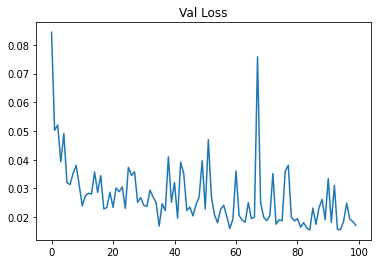

In [7]:
val_best_loss = 10000000
val_loss_list = []

if not os.path.exists(exp_path):
    os.mkdir(exp_path)
print("Training ", end='')
for epoch_idx in range(n_epochs):
    print('=', end='')
    # print(f"Training Epoch : [{epoch_idx+1}/{n_epochs}]===============================================================================")
    
    train(encoder,decoder,Q,opt,train_data_loader)    
    val_losses = validate(encoder,decoder,Q,val_data_loader) 
    val_loss_list.append(val_losses)
    if (val_losses < val_best_loss): 
        val_best_loss = val_losses
        # print("Saving Best Model =======================================>")
        torch.save(encoder, f'{exp_path}/encoder.pth.tar')
        torch.save(decoder, f'{exp_path}/decoder.pth.tar')
        torch.save(Q, f'{exp_path}/Q.pth.tar')
        
plt.figure()
plt.plot(val_loss_list)
plt.title("Val Loss")


# Inference for predicting conterfactual outcomes

In [8]:
#Load encoder
enc_path = f'{exp_path}/encoder.pth.tar'
encoder = torch.load(enc_path).to(DEVICE)
encoder.eval()
print(sum([np.prod(p.size()) for p in encoder.parameters()]))

166272


In [9]:
x_treat,t_treat,m_treat,y_treat,y_mask_treat,batch_ind_treat,treatment_effect = read_data_inference(data_path, fold = 'test',device = DEVICE,group = 'Treated')
print(x_treat.shape,t_treat.shape,m_treat.shape,y_treat.shape,y_mask_treat.shape,batch_ind_treat.shape,treatment_effect.shape)

x_control,t_control,m_control,y_control,y_mask_control,batch_ind_control = read_data_inference(data_path, fold = 'test',device = DEVICE,group = 'Control')
print(x_control.shape,t_control.shape,m_control.shape,y_control.shape,y_mask_control.shape,batch_ind_control.shape)

./data/sync6d-p10-seed-100/test-x_full.pth
Loading Treated Group
torch.Size([200, 25, 3]) torch.Size([200, 25, 3]) torch.Size([200, 25, 3]) torch.Size([200, 5]) torch.Size([1200]) torch.Size([200]) torch.Size([200, 5, 1])
./data/sync6d-p10-seed-100/test-x_full.pth
Loading Control Group
torch.Size([1000, 25, 3]) torch.Size([1000, 25, 3]) torch.Size([1000, 25, 3]) torch.Size([1000, 5]) torch.Size([1200]) torch.Size([1000])


torch.Size([200, 1600]) torch.Size([1000, 1600])
Features Shape :torch.Size([1200, 1600])
Flattened Features Shape :torch.Size([1200, 1600])
Fitting T-SNE on features ======>


/home/jupyter-jathurshan/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jupyter-jathurshan/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


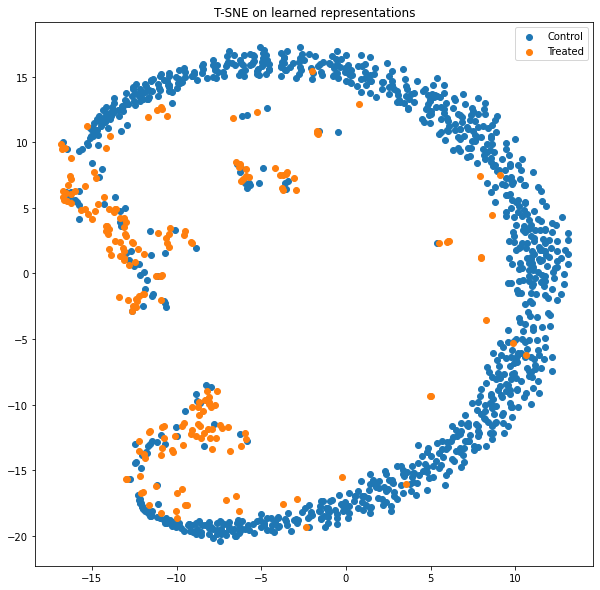

In [10]:
c_treat = get_representation(encoder,x_treat,m_treat).detach().to(DEVICE).requires_grad_(False)
c_control = get_representation(encoder,x_control,m_control).detach().to(DEVICE).requires_grad_(False)

print(c_treat.shape,c_control.shape)

tsne_feat = get_tsne(c_treat,c_control)

### For one Treated Sample

Tensor Shapes, B: torch.Size([1000, 1]), c_target: torch.Size([1600]), c_non_target: torch.Size([1000, 1600])


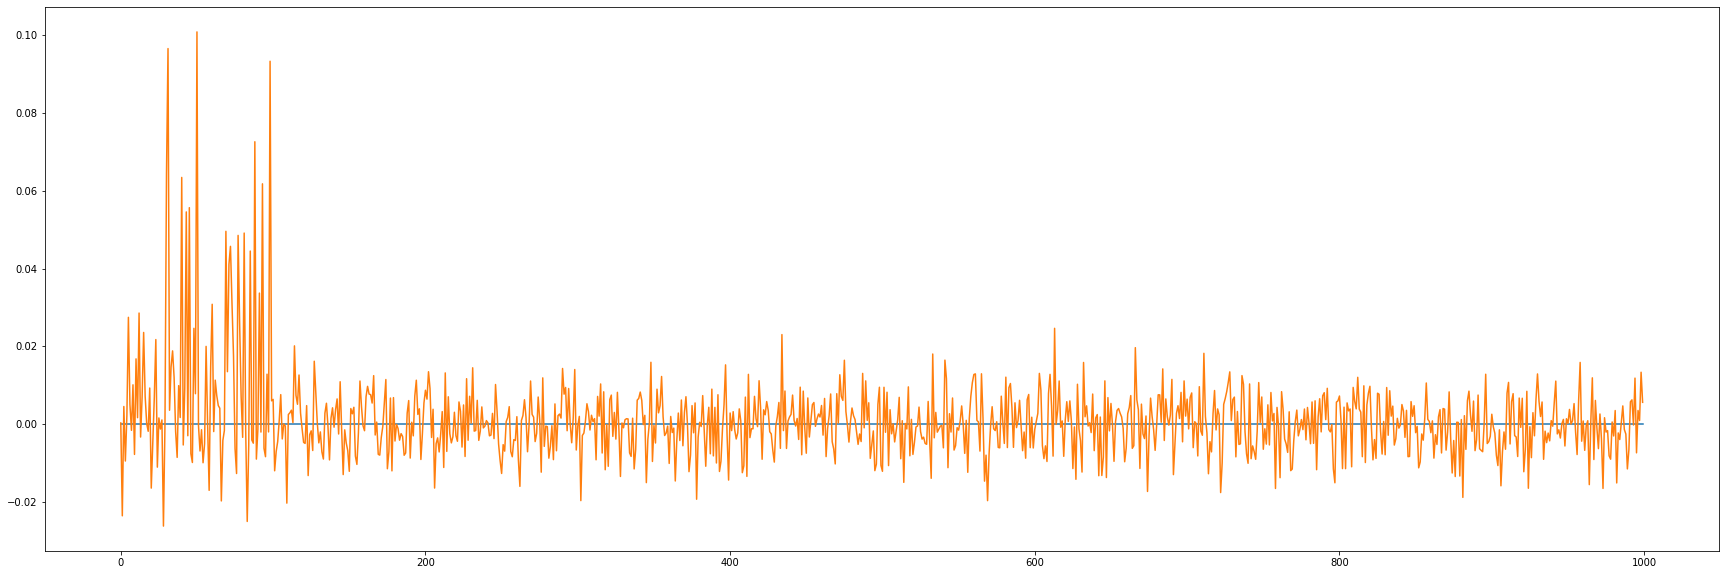

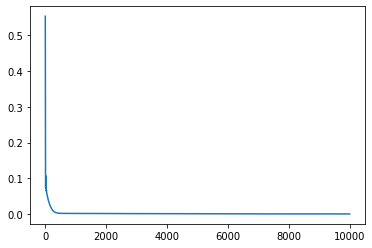

torch.Size([1000, 1]) torch.Size([1000, 5])
torch.Size([200, 5, 1]) torch.Size([5]) torch.Size([1, 5])


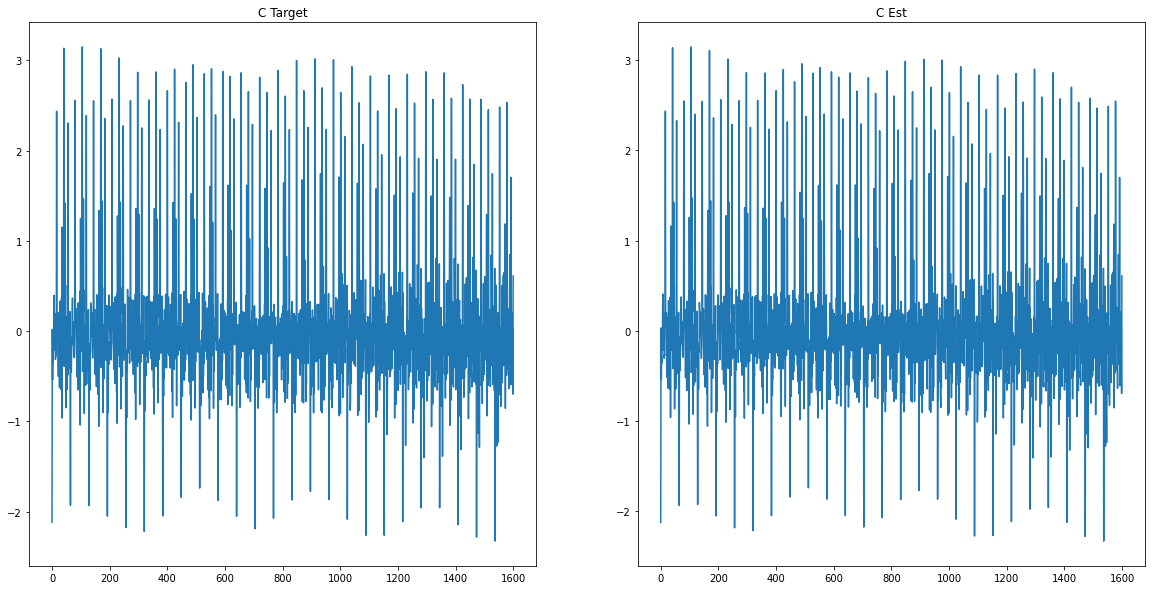

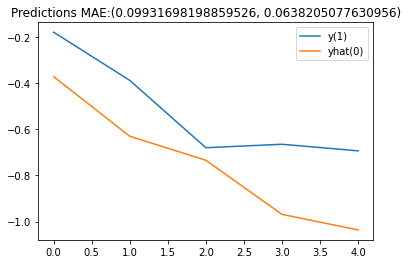

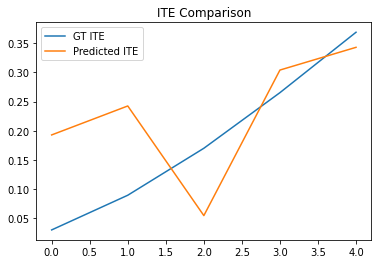

In [11]:
i = 12#14:0#12:2
B_treat = learn_B_for_one_sample(c_treat[i],c_control,num_iterations =10000,is_plot = True)

y_hat = estimate_y_one_sample(B_treat,y_control)

print(treatment_effect.shape,y_treat[i].shape,y_hat.shape)

plt.figure()
plt.plot(y_treat[i].squeeze().detach().cpu().numpy(),label = "y(1)")
plt.plot(y_hat.squeeze().detach().cpu().numpy(),label = "yhat(0)")
plt.title(f"Predictions MAE:{calculate_mae(y_hat,y_treat[i].unsqueeze(0),treatment_effect[i].squeeze().unsqueeze(0))}")
plt.legend(loc='best')

plt.figure()
plt.plot(treatment_effect[i].squeeze().detach().cpu().numpy(),label = "GT ITE" )
plt.plot((y_treat[i].unsqueeze(0) - y_hat).squeeze().detach().cpu().numpy(),label = "Predicted ITE" )
plt.title("ITE Comparison")
plt.legend(loc='best')

### For Multiple Treated Samples

Tensor Shapes, B: torch.Size([200, 1000]), c_target: torch.Size([200, 1600]), c_non_target: torch.Size([1000, 1600])


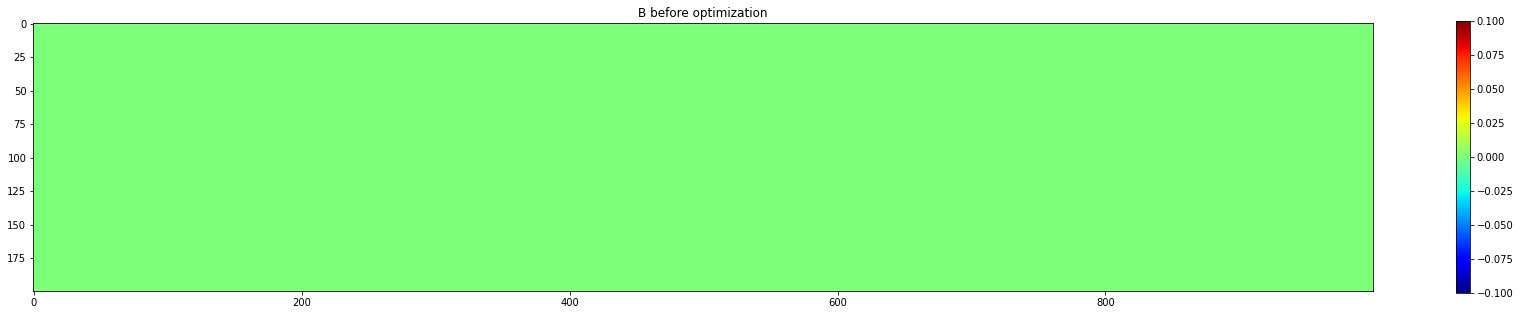

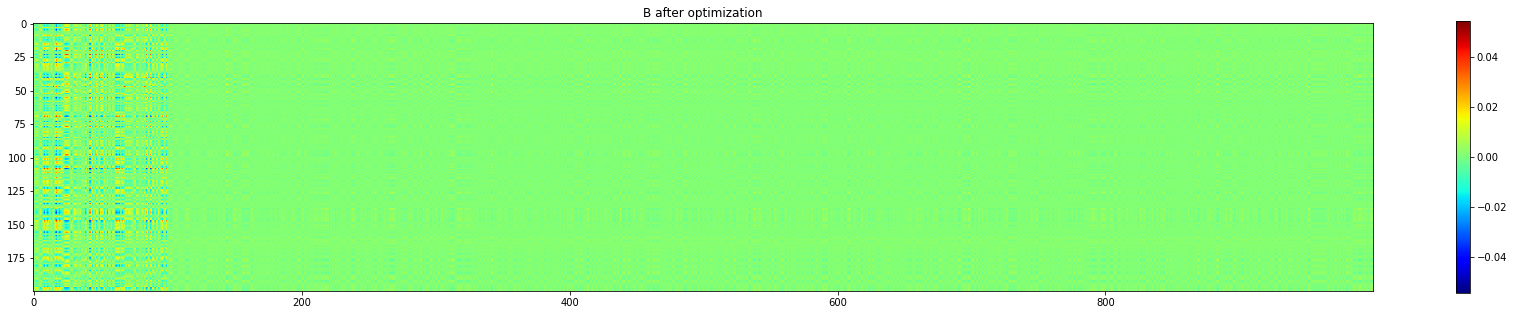

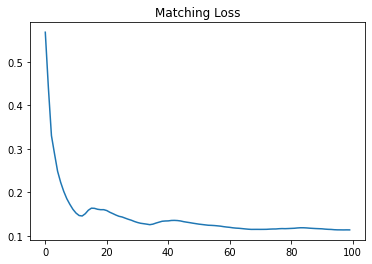

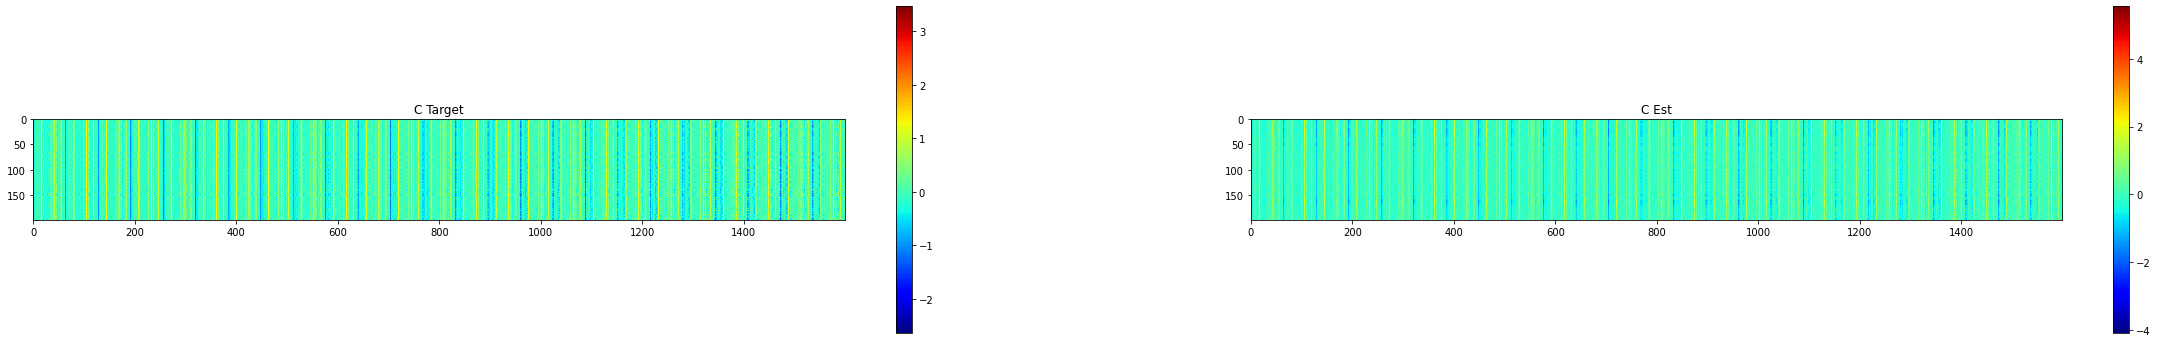

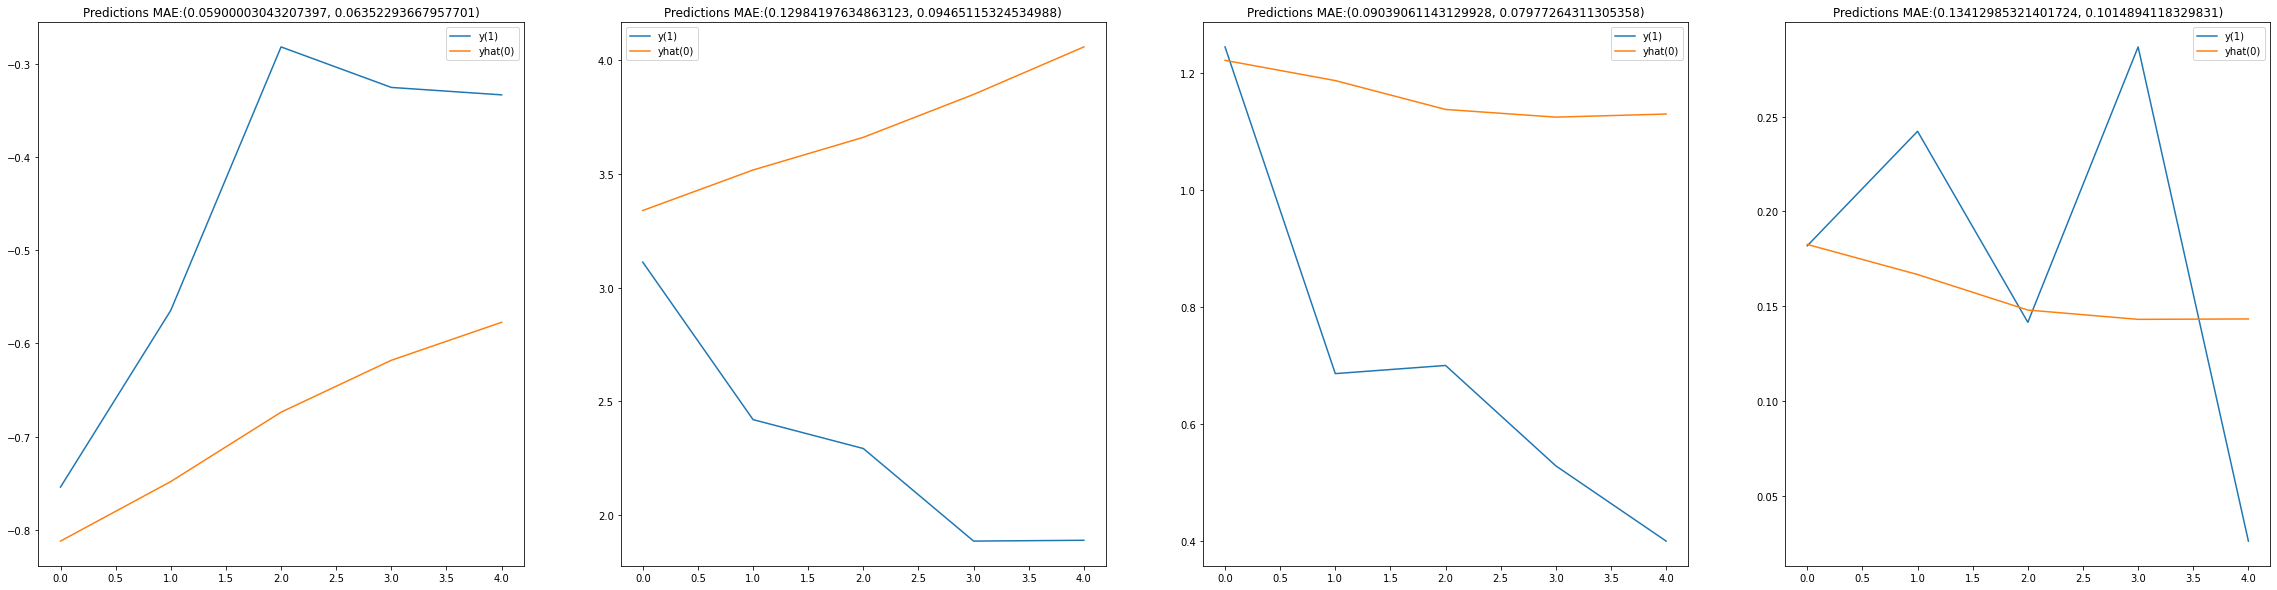

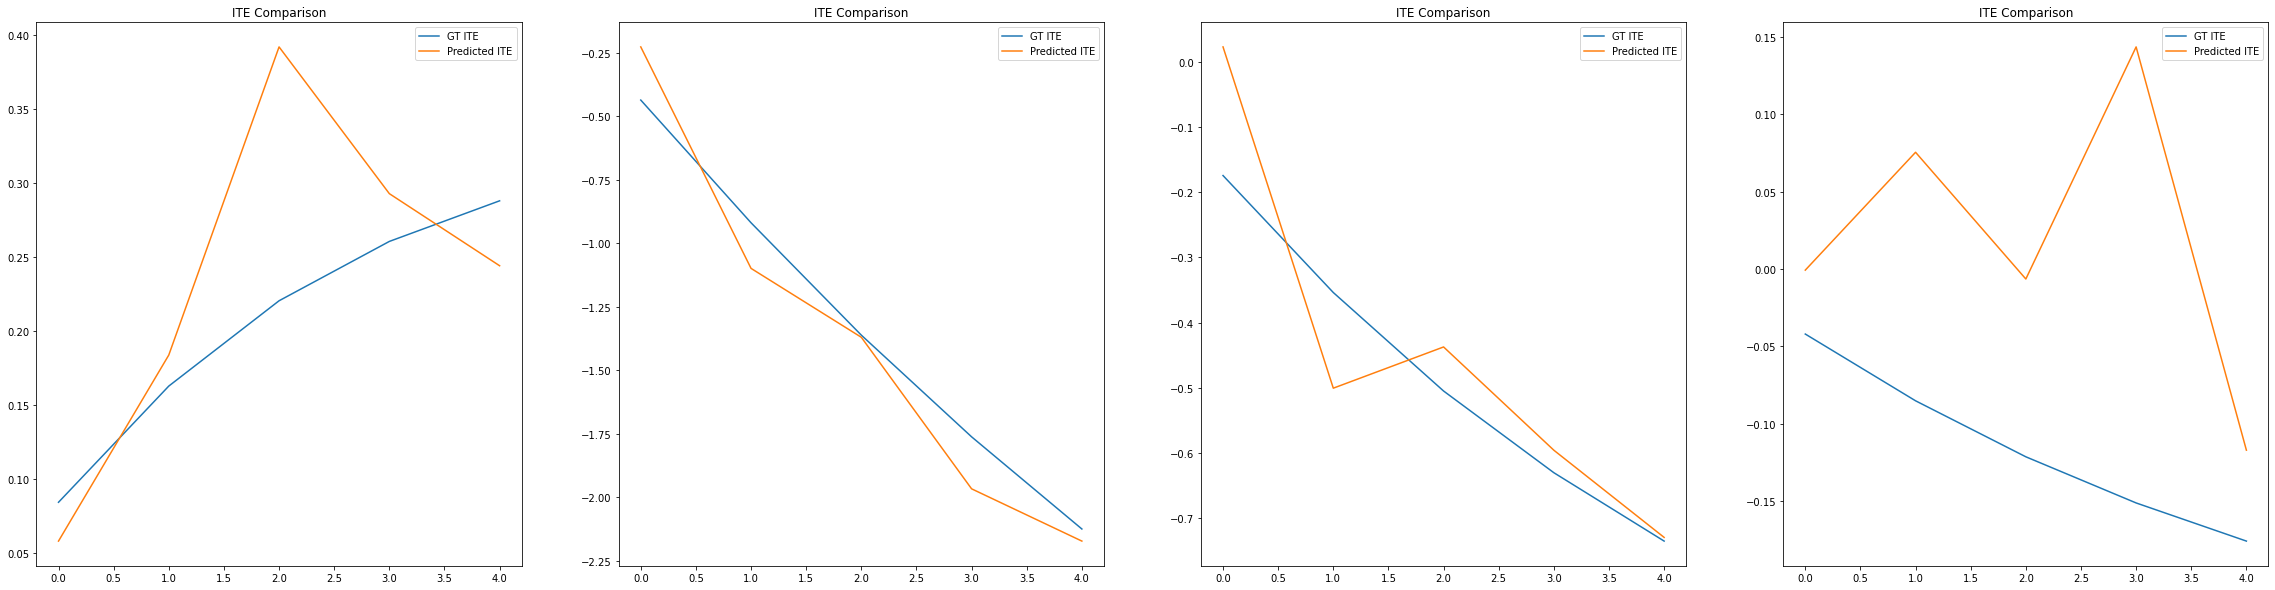

Experiment Results : MAE: 0.11391301167604756 (0.008456410634432303)


In [12]:
B_treat = learn_B(c_treat,c_control,num_iterations =100,is_plot = True)

y_hat_main = estimate_y(B_treat,y_control)

random_list = [3,5,1,6]
fig, axs = plt.subplots(1, 4, figsize = (40,10))
c = 0
for i in random_list:
    axs[c].plot(y_treat[i].squeeze().detach().cpu().numpy(),label = "y(1)")
    axs[c].plot(y_hat_main[i].squeeze().detach().cpu().numpy(),label = "yhat(0)")
    axs[c].set_title(f"Predictions MAE:{calculate_mae(y_hat_main[i],y_treat[i].unsqueeze(0),treatment_effect[i].squeeze().unsqueeze(0))}")
    axs[c].legend(loc='best')
    c+=1
plt.show()

fig, axs = plt.subplots(1, 4, figsize = (40,10))
c = 0
for i in random_list:
    axs[c].plot(treatment_effect[i].squeeze().detach().cpu().numpy(),label = "GT ITE" )
    axs[c].plot((y_treat[i].unsqueeze(0) - y_hat_main[i].unsqueeze(0)).squeeze().detach().cpu().numpy(),label = "Predicted ITE")
    axs[c].set_title("ITE Comparison")
    axs[c].legend(loc='best')
    c+=1
plt.show()
mae,mae_sd = calculate_mae(y_hat_main,y_treat,treatment_effect.squeeze())
print(f"Experiment Results : MAE: {mae} ({mae_sd})")
